In [40]:
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [41]:
def make_basis(n):
    basis=list(it.product([-1/2,1/2],repeat=n))
    inv={v:k for k,v in enumerate(basis)}
    return basis,inv

def get_bonds(width, height):
    if width%2!=0 or height%2!=0:
        raise ValueError("width and height must be even")
    bonds=[]
    for i in range(width):
        for j in range(height):
            i2,j2=(i+1)%width,j
            bonds.append((i+j*width,i2+j2*width,"j2"))
            i2,j2=i,(j+1)%height
            bonds.append((i+j*width,i2+j2*width,("j1" if j%2==0 else "j2")))
    return bonds

def make_H(width, height, j1):
    basis,inv=make_basis(width*height)
    bonds=get_bonds(width,height)
    rows=[]
    cols=[]
    data=[]
    for c,ket in enumerate(basis):
        diag=0
        for i,j,kind in bonds:
            #diagonal term
            if kind=="j1":
                diag+=ket[i]*ket[j]*j1
            elif kind=="j2":
                diag+=ket[i]*ket[j]
            #off-diagonal term
            if ket[i]!=ket[j]:
                bra=list(ket)
                bra[i],bra[j]=bra[j],bra[i]
                r=inv[tuple(bra)]
                rows.append(r)
                cols.append(c)
                data.append((j1 if kind=="j1" else 1)/2)
        rows.append(c)
        cols.append(c)
        data.append(diag)
    return sp.sparse.csr_matrix((data,(rows,cols)),shape=(len(basis),len(basis)))
def make_M(width, height):
    basis,inv=make_basis(width*height)
    rows=[]
    cols=[]
    data=[]
    for c,ket in enumerate(basis):
        value=0
        for x in range(width):
            for y in range(height):
                value+=ket[x+y*width]*(-1)**(x+y)
        rows.append(c)
        cols.append(c)
        data.append(np.abs(value))
    return sp.sparse.csr_matrix((data,(rows,cols)),shape=(len(basis),len(basis)))  


In [42]:
def staggered_magnetization(width, height, beta, j1):
    H=make_H(width,height,j1).todense()
    M=make_M(width,height).todense()
    eigvals,eigvecs=np.linalg.eigh(H)
    Z=np.sum(np.exp(-beta*eigvals))
    rho=np.exp(-beta*eigvals)/Z
    total=0
    for vec,r in zip(eigvecs.T,rho):
        total+=np.conjugate(vec)@M@vec.T*r
    return float(total)

In [43]:
def energy(width, height, beta, j1):
    H=make_H(width,height,j1).todense()
    eigvals=np.linalg.eigvalsh(H)
    Z=np.sum(np.exp(-beta*eigvals))
    rho=np.exp(-beta*eigvals)/Z
    return sum(eigvals*rho)

In [44]:
data=np.loadtxt("data.csv", delimiter=",")
js=data[:,0]
energies=data[:,1]
deltaEs=data[:,2]
magnetizations=data[:,3]
deltaMs=data[:,4]

/tmp/ipykernel_11364/84633176.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(total)


<ErrorbarContainer object of 3 artists>

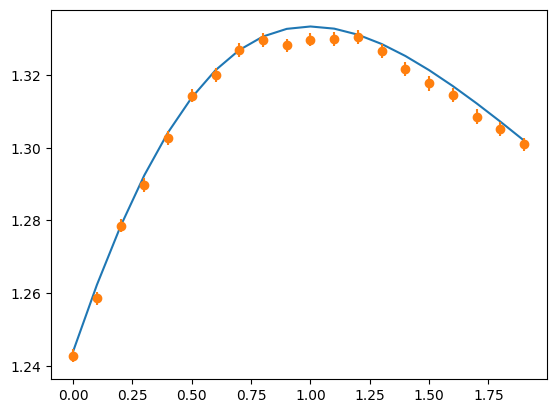

In [45]:
ms=[staggered_magnetization(2,2,16,j) for j in js]
plt.plot(js,ms)
plt.errorbar(js,magnetizations,yerr=deltaMs,fmt="o")

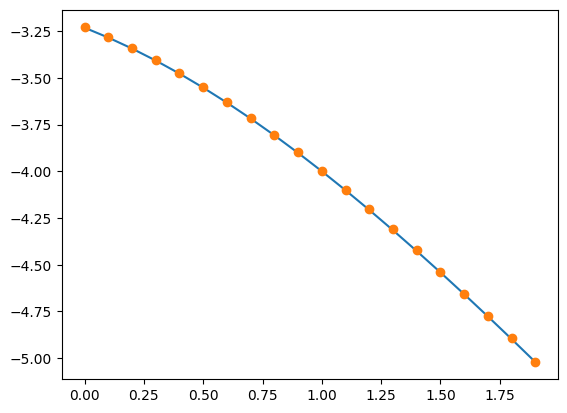

In [46]:
es=[energy(2,2,16,j) for j in js]
plt.plot(js,es)
plt.errorbar(js,energies,yerr=deltaEs,fmt="o")
plt.show()
    